In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from numbers_parser import Document
import pyarrow

In [9]:
# PARTIE 1.1 — Chargement & aperçu

plt.rcParams.update({"figure.figsize": (8, 4.5), "axes.grid": True})

CSV_PATH = Path("../Traitement-de-donnee/cac40.csv")
NUM_PATH = Path("../Traitement-de-donnee/close_cac40.numbers")

def read_csv_tolerant(p: Path):
    encodings = ["utf-8", "latin-1", "cp1252"]
    for enc in encodings:
        try:
            df = pd.read_csv(p, sep=None, engine="python", decimal=',', encoding=enc, low_memory=False)
            return df
        except Exception:
            continue
    return pd.read_csv(p)

csv_df = read_csv_tolerant(CSV_PATH)
print("[CSV]", "| shape:", csv_df.shape)
display(csv_df.head(10))

print("\nDtypes CSV:")
print(csv_df.dtypes)


[CSV] | shape: (533, 7)


,Date,Index,Open,High,Low,Close,Volume
0,2023-07-10,CAC40,990.15,997.11,988.11,988.56,123386.0
1,2023-01-20,CAC40,999.39,1003.24,999.08,998.35,163972.0
2,2023-04-03,CAC40,991.58,992.67,989.91,989.29,867344.0
3,2024-04-26,CAC40,NaN,1006.47,1001.66,1003.24,792459.0
4,2024-04-19,CAC40,1007.91,1009.4,1001.94,1002.77,943556.0
5,2023-11-20,CAC40,1000.79,1012.39,1000.68,999.60,362091.0
6,2023-02-02,CAC40,997.61,999.34,995.43,995.43,223099.0
7,2024-11-19,CAC40,1009.10,1011.76,1004.84,1008.07,434923.0
8,2024-05-08,CAC40,1006.18,1012.18,1002.44,1001.58,NaN
9,2023-06-05,CAC40,986.35,989.79,984.19,988.64,690189.0



Dtypes CSV:
Date       object
Index      object
Open      float64
High       object
Low        object
Close     float64
Volume    float64
dtype: object


In [10]:
#PARTIE 1.2 — Nettoyage et mise en forme ===

def mem_bytes(df: pd.DataFrame) -> int:
    return int(df.memory_usage(deep=True).sum())

def human_bytes(n: int) -> str:
    for u in ["B","KB","MB","GB","TB"]:
        if n < 1024: 
            return f"{n:.2f} {u}"
        n /= 1024
    return f"{n:.2f} PB"


def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename = {}
    for c in df.columns:
        cl = str(c).strip().lower()
        if cl in {"date","timestamp","time","datetime"}: rename[c] = "Date"
        elif cl in {"close","close price","cloture","cours de clôture","closing"}: rename[c] = "Close"
        elif cl in {"open","ouverture"}: rename[c] = "Open"
        elif cl in {"high","haut","max"}: rename[c] = "High"
        elif cl in {"low","bas","min"}: rename[c] = "Low"
        elif cl in {"volume","vol"}: rename[c] = "Volume"
        elif cl in {"index","indice"}: rename[c] = "Index"
    return df.rename(columns=rename)


raw_df = csv_df.copy()
raw_df = standardize_columns(raw_df)

before_shape = raw_df.shape
before_mem = mem_bytes(raw_df)
missing_before = raw_df.isna().sum()

if "Date" in raw_df.columns:
    raw_df["Date"] = pd.to_datetime(raw_df["Date"], errors="coerce", dayfirst=True)
for col in ["Open","High","Low","Close","Volume","Index"]:
    if col in raw_df.columns:
        raw_df[col] = pd.to_numeric(raw_df[col], errors="coerce")

df = raw_df.copy()

rows_before_na = len(df)
subset_cols = [c for c in ["Date","Close"] if c in df.columns]
df = df.dropna(subset=subset_cols)
rows_dropped_na = rows_before_na - len(df)

dups_before = df.duplicated(subset=["Date"]).sum() if "Date" in df.columns else 0
df = df.sort_values("Date").drop_duplicates(subset=["Date"], keep="last")

if "Date" in df.columns:
    df["Gap_Days"] = df["Date"].diff().dt.days
    gaps = df[df["Gap_Days"] > 3][["Date","Gap_Days"]]
else:
    gaps = pd.DataFrame(columns=["Date","Gap_Days"])


after_shape = df.shape
after_mem = mem_bytes(df)
missing_after = df.isna().sum()

print("---RAPPORT DE NETTOYAGE---")
print(f"- Lignes initiales : {before_shape[0]} | après nettoyage : {after_shape[0]}")
print(f"- Colonnes : {before_shape[1]} -> {after_shape[1]}")
print(f"- Lignes supprimées (NaN critiques) : {rows_dropped_na}")
print(f"- Doublons supprimés : {dups_before}")
print(f"- Gaps > 3 jours : {len(gaps)}")
if len(gaps) > 0:
    print("  Aperçu des gaps :")
    display(gaps.head(10))
print(f"- Mémoire avant : {human_bytes(before_mem)} | après : {human_bytes(after_mem)}")
print(f"- Gain : {human_bytes(before_mem - after_mem)}")
print("\nRésumé des valeurs manquantes (avant → après) :")
for col in raw_df.columns:
    before = missing_before.get(col, 0)
    after = missing_after.get(col, 0) if col in missing_after else "supprimée"
    print(f"  {col:<10} : {before} → {after}")

clean_path = Path("cac40_clean_step2.csv")
df.to_csv(clean_path, index=False)
print(f"Fichier nettoyé exporté vers : {clean_path}")
display(df.head(10))

---RAPPORT DE NETTOYAGE---
- Lignes initiales : 533 | après nettoyage : 206
- Colonnes : 7 -> 8
- Lignes supprimées (NaN critiques) : 322
- Doublons supprimés : 5
- Gaps > 3 jours : 24
  Aperçu des gaps :


,Date,Gap_Days
305,2023-02-01,20.0
515,2023-03-01,18.0
80,2023-04-01,21.0
208,2023-05-01,19.0
91,2023-06-01,20.0
467,2023-07-02,20.0
322,2023-08-02,21.0
94,2023-09-01,20.0
383,2023-10-01,20.0
148,2023-11-01,21.0


- Mémoire avant : 145.74 KB | après : 14.48 KB
- Gain : 131.26 KB

Résumé des valeurs manquantes (avant → après) :
  Date       : 0 → 0
  Index      : 0 → 206
  Open       : 6 → 2
  High       : 5 → 5
  Low        : 2 → 1
  Close      : 4 → 0
  Volume     : 10 → 5
Fichier nettoyé exporté vers : cac40_clean_step2.csv


,Date,Index,Open,High,Low,Close,Volume,Gap_Days
350,2023-01-02,NaN,996.29,998.63,981.68,999.36,266782.0,NaN
503,2023-01-03,NaN,991.23,992.53,983.42,991.34,554151.0,1.0
145,2023-01-05,NaN,986.32,988.43,984.63,990.25,592750.0,2.0
250,2023-01-06,NaN,992.25,1000.46,984.65,992.80,225829.0,1.0
238,2023-01-08,NaN,985.43,988.20,982.87,985.12,719003.0,2.0
313,2023-01-09,NaN,988.76,994.70,982.95,987.71,700600.0,1.0
19,2023-01-11,NaN,997.05,1001.65,995.50,1002.50,922614.0,2.0
140,2023-01-12,NaN,1004.54,1011.20,996.64,999.28,349265.0,1.0
305,2023-02-01,NaN,1001.64,1004.90,998.99,1001.74,440686.0,20.0
6,2023-02-02,NaN,997.61,999.34,995.43,995.43,223099.0,1.0


Index(['Date', 'Index', 'Open', 'High', 'Low', 'Close', 'Volume', 'Gap_Days'], dtype='object')


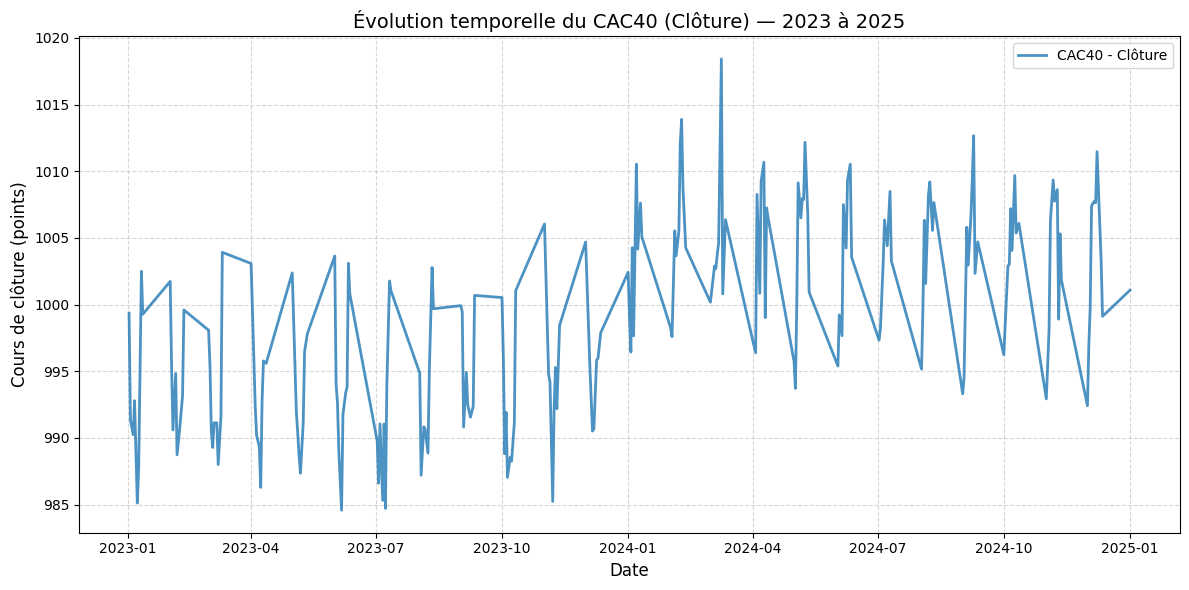

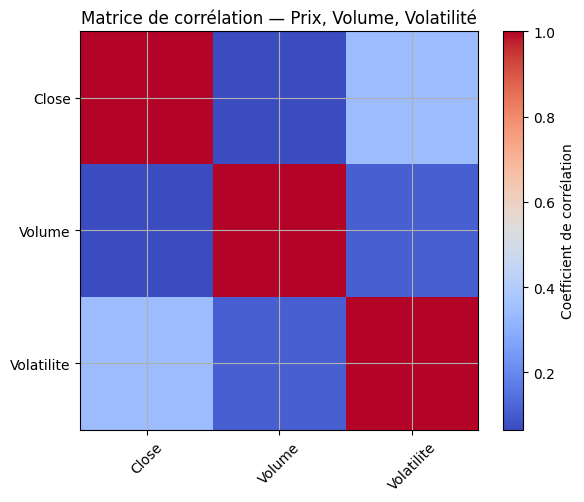

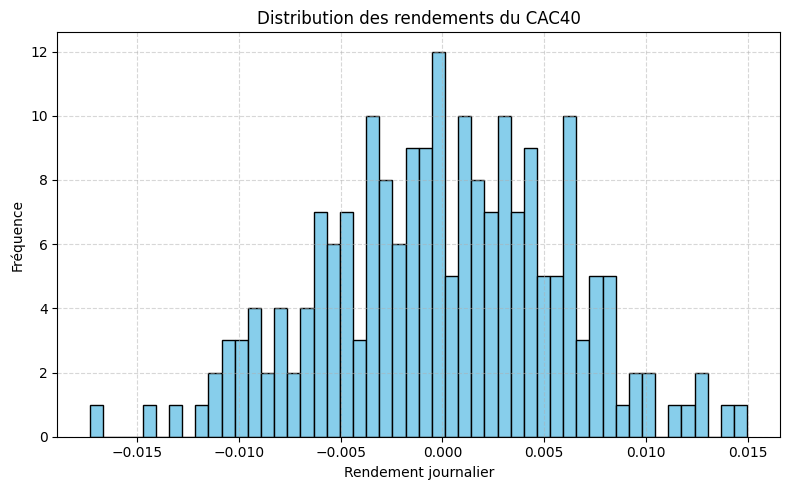

        Rendement  Volatilite
count  205.000000  176.000000
mean     0.000025    0.005914
std      0.005822    0.000640
min     -0.017301    0.004727
25%     -0.003687    0.005486
50%      0.000000    0.005757
75%      0.004138    0.006163
max      0.014974    0.007506


In [9]:
# Partie 1.3 - Analyse de base 

df = pd.read_csv("cac40_clean_step2.csv")
print(df.columns)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='CAC40 - Clôture', linewidth=2, color='tab:blue', alpha=0.8)
plt.title("Évolution temporelle du CAC40 (Clôture) — 2023 à 2025", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cours de clôture (points)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

df['Rendement'] = df['Close'].pct_change()

df['Volatilite'] = df['Rendement'].rolling(window=30).std()

cols_to_corr = ['Close', 'Volume', 'Volatilite']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Coefficient de corrélation")
plt.xticks(range(len(cols_to_corr)), cols_to_corr, rotation=45)
plt.yticks(range(len(cols_to_corr)), cols_to_corr)
plt.title("Matrice de corrélation — Prix, Volume, Volatilité")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df['Rendement'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des rendements du CAC40")
plt.xlabel("Rendement journalier")
plt.ylabel("Fréquence")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(df[['Rendement', 'Volatilite']].describe())

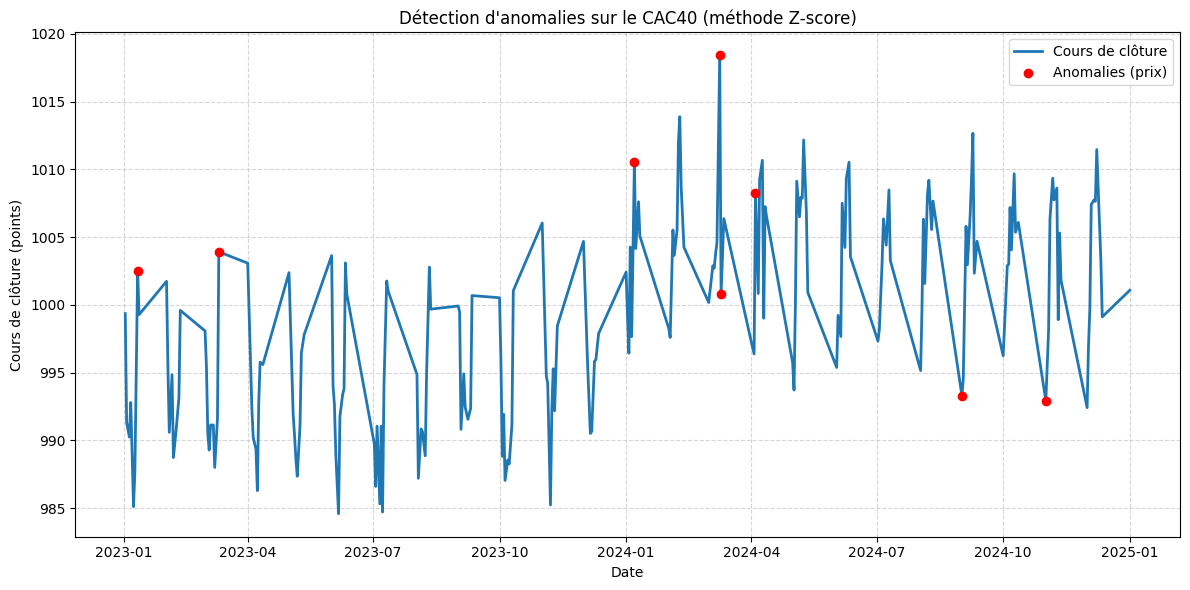

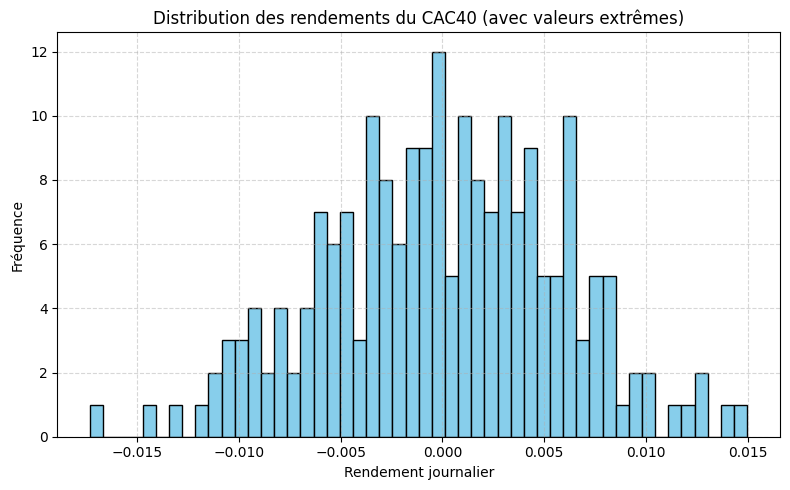

Anomalies détectées :
 - Prix (rendement): 8
 - Volume: 0
 - Volatilité: 11


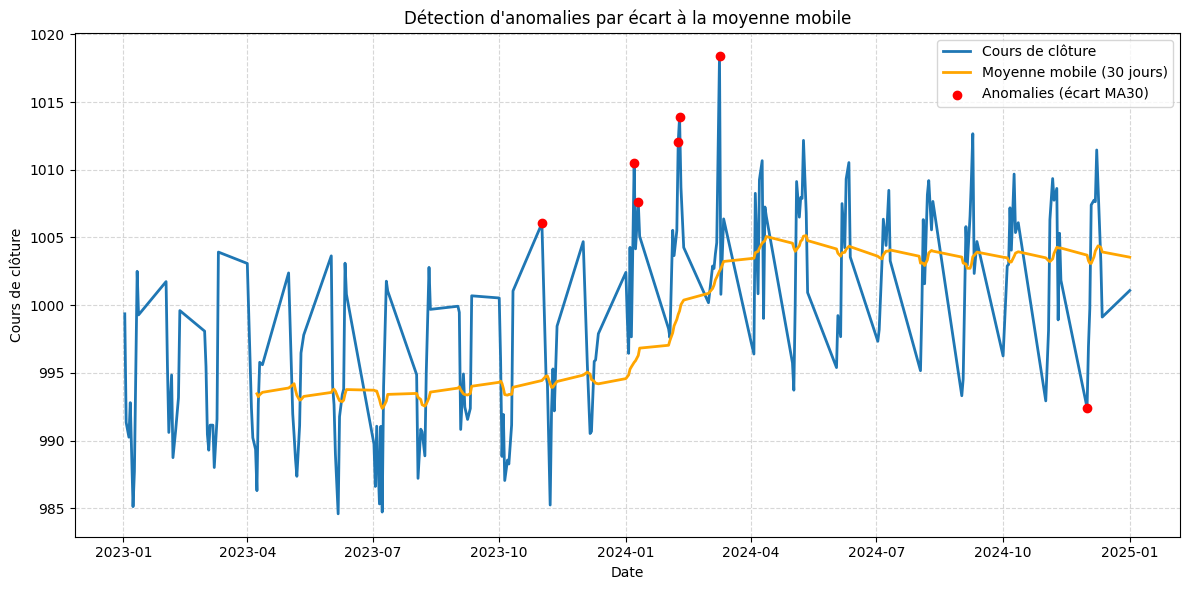

Anomalies détectées (écart à la moyenne mobile) :
      Date   Close        MA30  Ecart_MA30
2023-11-01 1006.04  994.434333   11.605667
2024-01-07 1010.53  995.774333   14.755667
2024-01-10 1007.61  996.285000   11.325000
2024-02-08 1012.04  999.312667   12.727333
2024-02-09 1013.89  999.574333   14.315667
2024-03-09 1018.42 1002.525000   15.895000
2024-12-01  992.42 1003.694000  -11.274000


In [11]:
# Partier 2 - Detection d'anomalies

df = pd.read_csv("cac40_clean_step2.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Calcul du rendement et de la volatilité glissante
df['Rendement'] = df['Close'].pct_change()
df['Volatilite'] = df['Rendement'].rolling(window=30).std()

# Détection d’anomalies par Z-score
# On considère comme anomalie les valeurs dont le Z-score dépasse 2 ou -2
def detect_anomalies_zscore(series, threshold=2):
    mean, std = series.mean(), series.std()
    z_scores = (series - mean) / std
    return np.abs(z_scores) > threshold

df['Anomalie_Close'] = detect_anomalies_zscore(df['Rendement'])
df['Anomalie_Volume'] = detect_anomalies_zscore(df['Volume'])
df['Anomalie_Volatilite'] = detect_anomalies_zscore(df['Volatilite'])

# Visualisation des anomalies sur la courbe du CAC40
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Cours de clôture', linewidth=2)

# Points rouges = anomalies de prix
plt.scatter(df.loc[df['Anomalie_Close'], 'Date'],
            df.loc[df['Anomalie_Close'], 'Close'],
            color='red', label='Anomalies (prix)', zorder=5)

plt.title("Détection d'anomalies sur le CAC40 (méthode Z-score)")
plt.xlabel("Date")
plt.ylabel("Cours de clôture (points)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogramme des rendements pour voir les extrêmes
plt.figure(figsize=(8,5))
plt.hist(df['Rendement'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des rendements du CAC40 (avec valeurs extrêmes)")
plt.xlabel("Rendement journalier")
plt.ylabel("Fréquence")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Résumé du nombre d’anomalies détectées
print("Anomalies détectées :")
print(f" - Prix (rendement): {df['Anomalie_Close'].sum()}")
print(f" - Volume: {df['Anomalie_Volume'].sum()}")
print(f" - Volatilité: {df['Anomalie_Volatilite'].sum()}")

# Moyenne mobile et écart
df['MA30'] = df['Close'].rolling(window=30).mean()
df['Ecart_MA30'] = df['Close'] - df['MA30']

# Anomalie si l'écart dépasse 2 écarts-types
seuil = 2 * df['Ecart_MA30'].std()
df['Anomalie_MA'] = abs(df['Ecart_MA30']) > seuil

# Visualisation
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Cours de clôture', linewidth=2)
plt.plot(df['Date'], df['MA30'], label='Moyenne mobile (30 jours)', color='orange', linewidth=2)
plt.scatter(df.loc[df['Anomalie_MA'], 'Date'],
            df.loc[df['Anomalie_MA'], 'Close'],
            color='red', label='Anomalies (écart MA30)', zorder=5)
plt.title("Détection d'anomalies par écart à la moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Cours de clôture")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

anomalies = df.loc[df['Anomalie_MA'], ['Date', 'Close', 'MA30', 'Ecart_MA30']]
print("Anomalies détectées (écart à la moyenne mobile) :")
print(anomalies.to_string(index=False))

In [12]:
# Partie 3.1 - Indicateurs statistiques de marché

# Moyenne mobile courte (10 jours)
df['MA_10'] = df['Close'].rolling(window=10).mean()

# Moyenne mobile longue (20 jours)
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Momentum long (20 jours) : différence entre le prix actuel et le prix 20 jours avant
df['Momentum_20'] = df['Close'] - df['Close'].shift(20)

# aperçu des nouvelles colonnes
df[['Date', 'Close', 'MA_10', 'MA_20', 'Momentum_20']].head(25)


,Date,Close,MA_10,MA_20,Momentum_20
0,2023-01-02,999.36,NaN,NaN,NaN
1,2023-01-03,991.34,NaN,NaN,NaN
2,2023-01-05,990.25,NaN,NaN,NaN
3,2023-01-06,992.80,NaN,NaN,NaN
4,2023-01-08,985.12,NaN,NaN,NaN
5,2023-01-09,987.71,NaN,NaN,NaN
6,2023-01-11,1002.50,NaN,NaN,NaN
7,2023-01-12,999.28,NaN,NaN,NaN
8,2023-02-01,1001.74,NaN,NaN,NaN
9,2023-02-02,995.43,994.553,NaN,NaN


In [13]:
# Partie 3.2 - Règle de prédiction simple 

# Cible réelle : 1 si le cours du lendemain monte, 0 sinon
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Règle :
# - MA_10 > MA_20  -> tendance haussière court terme > long terme
# - Momentum_20 > 0 -> le prix est plus haut qu'il y a 20 jours
condition_hausse = (df['MA_10'] > df['MA_20']) & (df['Momentum_20'] > 0)

# Prédiction de la règle : 1 = hausse prédite, 0 = baisse prédite
df['Pred_Rule'] = np.where(condition_hausse, 1, 0)

# On retire les lignes où les features ou la cible sont NaN (début/fin de série)
mask_valid = df[['MA_10', 'MA_20', 'Momentum_20', 'Target']].notna().all(axis=1)

# Calcul de la précision (accuracy)
accuracy = (df.loc[mask_valid, 'Pred_Rule'] == df.loc[mask_valid, 'Target']).mean()
print(f"Précision du modèle basé sur la règle statistique : {accuracy:.2%}")


Précision du modèle basé sur la règle statistique : 48.39%


In [ ]:
# Partie 3.3 - Sauvegarde des données traitées au format Parquet 

colonnes_a_garder = [
    'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Gap_Days',
    'Rendement', 'Volatilite',
    'MA_10', 'MA_20', 'Momentum_20',
    'Target', 'Pred_Rule'
]

df_parquet = df[colonnes_a_garder].copy()

# Sauvegarde en Parquet avec fastparquet (pour éviter les bugs pyarrow)
df_parquet.to_parquet(
    "cac40_features_step3.parquet",
    index=False,
    engine="fastparquet"  
)

print("Fichier Parquet sauvegardé sous 'cac40_features_step3.parquet'.")

Fichier Parquet sauvegardé sous 'cac40_features_step3.parquet'.


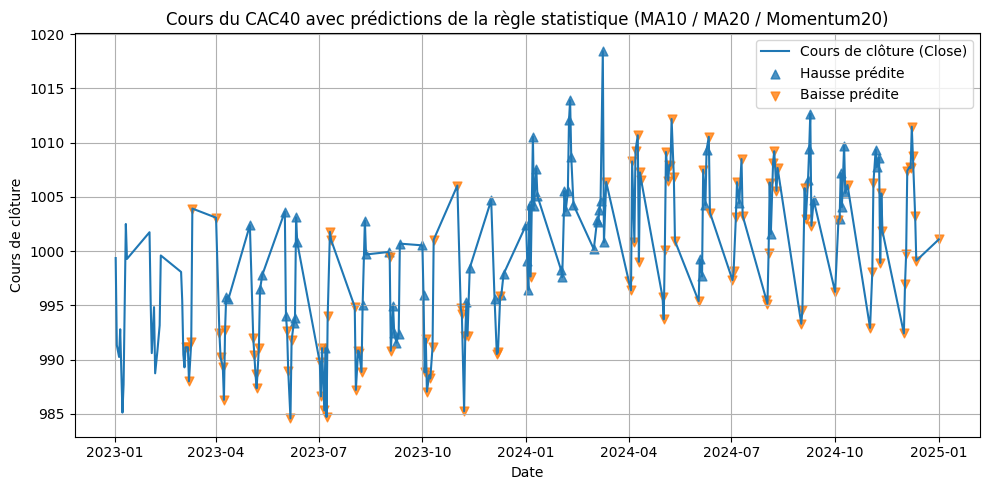

In [19]:
# Partie 3.4 : Visualisation des prédictions de la règle 

fig, ax = plt.subplots(figsize=(10, 5))

# Courbe du cours de clôture
ax.plot(df['Date'], df['Close'], label='Cours de clôture (Close)')

# Points où la règle prédit une hausse (on affiche sur la courbe)
buy_points = df[mask_valid & (df['Pred_Rule'] == 1)]
sell_points = df[mask_valid & (df['Pred_Rule'] == 0)]

ax.scatter(buy_points['Date'], buy_points['Close'],
           marker='^', s=40, label='Hausse prédite', alpha=0.8)

ax.scatter(sell_points['Date'], sell_points['Close'],
           marker='v', s=40, label='Baisse prédite', alpha=0.8)

ax.set_title("Cours du CAC40 avec prédictions de la règle statistique (MA10 / MA20 / Momentum20)")
ax.set_xlabel("Date")
ax.set_ylabel("Cours de clôture")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Partie 4 - Prédiction avec Machine Learning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt



In [21]:
# Partie 4.2 - Création des variables de features pour le modèle 

# Moyennes mobiles
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()   # on le recalcule au cas où

# Momentum sur 5 jours
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)

# EMA (moyenne mobile exponentielle) sur 5 jours
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()

# ROC : taux de variation sur 5 jours
df['ROC_5'] = df['Close'].pct_change(5)

# Volatilité sur 5 jours (écart-type des rendements)
df['Volatility_5'] = df['Close'].pct_change().rolling(5).std()

# High-Low range : écart entre le plus haut et le plus bas de la journée
df['High_Low_Range'] = df['High'] - df['Low']

# Moyennes mobiles sur le volume
df['Volume_SMA_5'] = df['Volume'].rolling(5).mean()
df['Volume_SMA_10'] = df['Volume'].rolling(10).mean()

# Cible : 1 si le cours du lendemain monte, 0 sinon (on le redéfinit proprement)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Aperçu des nouvelles colonnes
df[['Date', 'Close',
    'MA_5', 'MA_20', 'EMA_5',
    'Momentum_5', 'ROC_5', 'Volatility_5',
    'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10',
    'Target']].head(20)

,Date,Close,MA_5,MA_20,EMA_5,Momentum_5,ROC_5,Volatility_5,High_Low_Range,Volume_SMA_5,Volume_SMA_10,Target
0,2023-01-02,999.36,NaN,NaN,999.360000,NaN,NaN,NaN,16.95,NaN,NaN,0
1,2023-01-03,991.34,NaN,NaN,996.686667,NaN,NaN,NaN,9.11,NaN,NaN,0
2,2023-01-05,990.25,NaN,NaN,994.541111,NaN,NaN,NaN,3.80,NaN,NaN,1
3,2023-01-06,992.80,NaN,NaN,993.960741,NaN,NaN,NaN,15.81,NaN,NaN,0
4,2023-01-08,985.12,991.774,NaN,991.013827,NaN,NaN,NaN,5.33,471703.0,NaN,1
5,2023-01-09,987.71,989.444,NaN,989.912551,-11.65,-0.011657,0.005287,11.75,558466.6,NaN,1
6,2023-01-11,1002.50,991.676,NaN,994.108368,11.16,0.011257,0.008263,6.15,632159.2,NaN,0
7,2023-01-12,999.28,993.482,NaN,995.832245,9.03,0.009119,0.008528,14.56,583462.2,NaN,1
8,2023-02-01,1001.74,995.270,NaN,997.801497,8.94,0.009005,0.008525,5.91,626433.6,NaN,0
9,2023-02-02,995.43,997.332,NaN,997.010998,10.31,0.010466,0.008138,3.91,527252.8,499477.9,0


In [22]:
# Partie 4.3 - Préparation des données pour RandomForest 

feature_cols = [
    'MA_5', 'MA_20', 'EMA_5',
    'Momentum_5', 'ROC_5', 'Volatility_5',
    'High_Low_Range', 'Volume_SMA_5', 'Volume_SMA_10'
]

# On garde uniquement les lignes où toutes les features + la cible sont définies
df_ml = df.dropna(subset=feature_cols + ['Target']).copy()

X = df_ml[feature_cols]
y = df_ml['Target']

# Split temporel : on ne mélange pas le temps (pas de shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% dernières observations pour le test
    shuffle=False
)

print("Taille train :", X_train.shape)
print("Taille test  :", X_test.shape)

Taille train : (104, 9)
Taille test  : (27, 9)


In [23]:
# Partie 4.4 - Entraînement du modèle RandomForest et évaluation 

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy du RandomForest sur le jeu de test : {accuracy_rf:.2%}\n")

# Rapport détaillé
print("Classification report :")
print(classification_report(y_test, y_pred))

# Matrice de confusion (optionnel)
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Accuracy du RandomForest sur le jeu de test : 74.07%

Classification report :
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.83      0.67      0.74        15

    accuracy                           0.74        27
   macro avg       0.75      0.75      0.74        27
weighted avg       0.76      0.74      0.74        27

Matrice de confusion :
[[10  2]
 [ 5 10]]


In [25]:
# Partie 4.5 - Rattacher les prédictions au DataFrame principal 

# On crée une colonne vide dans df_ml
df_ml['Pred_RF'] = np.nan

# On remplit uniquement les index du jeu de test
df_ml.loc[X_test.index, 'Pred_RF'] = y_pred

# On répercute dans df (même index)
df['Pred_RF'] = np.nan
df.loc[df_ml.index, 'Pred_RF'] = df_ml['Pred_RF']

df[['Date', 'Close', 'Target', 'Pred_RF']].tail(15)


,Date,Close,Target,Pred_RF
191,2024-11-09,1008.62,0,0.0
192,2024-11-10,998.91,1,0.0
193,2024-11-11,1005.31,0,1.0
194,2024-11-12,1001.84,0,0.0
195,2024-12-01,992.42,1,1.0
196,2024-12-02,996.94,1,1.0
197,2024-12-03,999.77,1,0.0
198,2024-12-04,1007.40,1,0.0
199,2024-12-06,1007.75,0,0.0
200,2024-12-07,1007.64,1,1.0


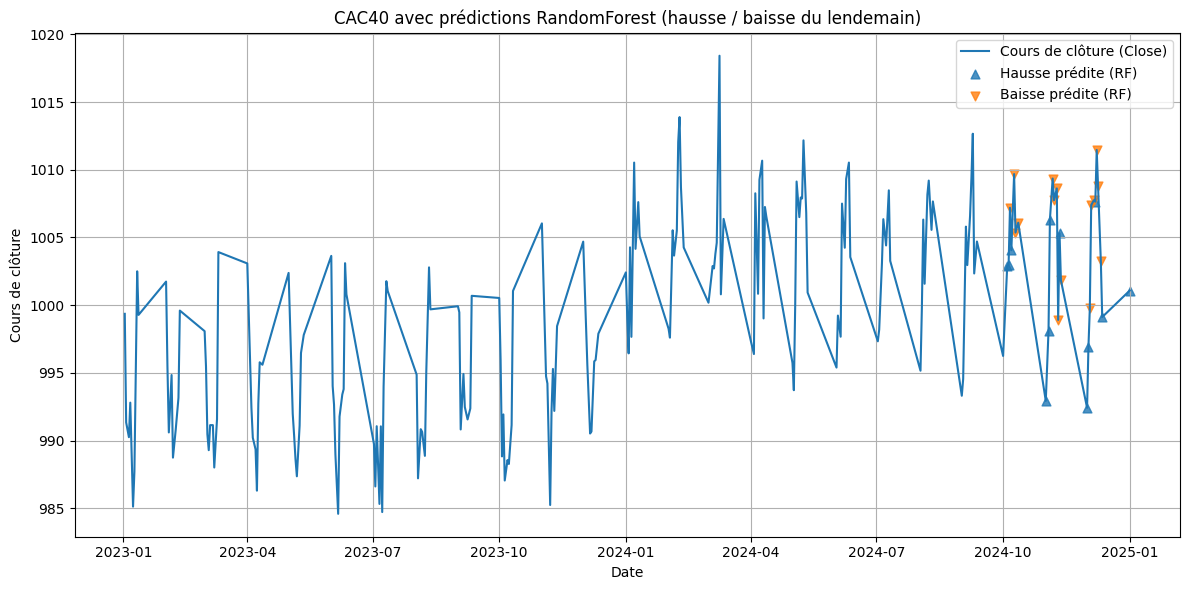

In [26]:
# Partie 4.6 - Visualisation du CAC40 avec les prédictions du RandomForest 

mask_pred = df['Pred_RF'].notna()

fig, ax = plt.subplots(figsize=(12, 6))

# Cours de clôture
ax.plot(df['Date'], df['Close'], label='Cours de clôture (Close)')

# Points où le modèle prédit une hausse (1)
pred_up = df[mask_pred & (df['Pred_RF'] == 1)]
ax.scatter(pred_up['Date'], pred_up['Close'],
           marker='^', s=40, label='Hausse prédite (RF)', alpha=0.8)

# Points où le modèle prédit une baisse (0)
pred_down = df[mask_pred & (df['Pred_RF'] == 0)]
ax.scatter(pred_down['Date'], pred_down['Close'],
           marker='v', s=40, label='Baisse prédite (RF)', alpha=0.8)

ax.set_title("CAC40 avec prédictions RandomForest (hausse / baisse du lendemain)")
ax.set_xlabel("Date")
ax.set_ylabel("Cours de clôture")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()